<a href="https://colab.research.google.com/github/fadhilrobbani/ecdsa_ed25519/blob/main/ecdsa_ed25519.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random


def find_inverse(number, modulus):
    return pow(number, -1, modulus)


class Point:
    def __init__(self, x, y, curve_config):
        a = curve_config['a']
        b = curve_config['b']
        p = curve_config['p']

        if (y ** 2) % p != (x ** 3 + a * x + b) % p:
            raise Exception("The point is not on the curve")

        self.x = x
        self.y = y
        self.curve_config = curve_config

    def is_equal_to(self, point):
        return self.x == point.x and self.y == point.y

    def add(self, point):
        p = self.curve_config['p']

        if self.is_equal_to(point):
            slope = (3 * point.x ** 2) * find_inverse(2 * point.y, p) % p
        else:
            slope = (point.y - self.y) * find_inverse(point.x - self.x, p) % p

        x = (slope ** 2 - point.x - self.x) % p
        y = (slope * (self.x - x) - self.y) % p
        return Point(x, y, self.curve_config)

    def multiply(self, times):
        current_point = self
        current_coefficient = 1

        pervious_points = []
        while current_coefficient < times:
            # store current point as a previous point
            pervious_points.append((current_coefficient, current_point))
            # if we can multiply our current point by 2, do it
            if 2 * current_coefficient <= times:
                current_point = current_point.add(current_point)
                current_coefficient = 2 * current_coefficient
            # if we can't multiply our current point by 2, let's find the biggest previous point to add to our point
            else:
                next_point = self
                next_coefficient = 1
                for (previous_coefficient, previous_point) in pervious_points:
                    if previous_coefficient + current_coefficient <= times:
                        if previous_point.x != current_point.x:
                            next_coefficient = previous_coefficient
                            next_point = previous_point
                current_point = current_point.add(next_point)
                current_coefficient = current_coefficient + next_coefficient

        return current_point


secp256k1_curve_config = {
    'a': 0,
    'b': 7,
    'p': 115792089237316195423570985008687907853269984665640564039457584007908834671663
}
x = 55066263022277343669578718895168534326250603453777594175500187360389116729240
y = 32670510020758816978083085130507043184471273380659243275938904335757337482424
n = 115792089237316195423570985008687907852837564279074904382605163141518161494337
g_point = Point(x, y, secp256k1_curve_config)


def sign_message(message, private_key):
    k = random.randint(1, n)
    r_point = g_point.multiply(k)
    r = r_point.x % n
    if r == 0:
        return sign_message(message, private_key)
    k_inverse = find_inverse(k, n)
    s = k_inverse * (message + r * private_key) % n
    return r, s


def verify_signature(signature, message, public_key):
    (r, s) = signature
    s_inverse = find_inverse(s, n)
    u = message * s_inverse % n
    v = r * s_inverse % n
    c_point = g_point.multiply(u).add(public_key.multiply(v))
    return c_point.x == r


# test starts here
private_key = 123456789012345  # any random integer
public_key = g_point.multiply(private_key)
message = 12345  # any integer

signature = sign_message(message, private_key)
print('Signature: ', signature)
print('Is valid: ', verify_signature(signature, message, public_key))

Signature:  (69795767850075901884987945680984892692957087170829876218989482416729943206973, 34613871983054052195503414894697895648695052975435571570955879640384030655639)
Is valid:  True


In [ ]:
import hashlib
import numpy as np
import matplotlib.pyplot as plt

def sha512(s):
    return hashlib.sha512(s).digest()

# Base field Z_p
p = 2**255 - 19

def modp_inv(x):
    return pow(x, p-2, p)

# Curve constant
d = -121665 * modp_inv(121666) % p

# Group order
q = 2**252 + 27742317777372353535851937790883648493

def sha512_modq(s):
    return int.from_bytes(sha512(s), "little") % q

## Then follows functions to perform point operations.

# Points are represented as tuples (X, Y, Z, T) of extended
# coordinates, with x = X/Z, y = Y/Z, x*y = T/Z

def point_add(P, Q):
    A, B = (P[1]-P[0]) * (Q[1]-Q[0]) % p, (P[1]+P[0]) * (Q[1]+Q[0]) % p;
    C, D = 2 * P[3] * Q[3] * d % p, 2 * P[2] * Q[2] % p;
    E, F, G, H = B-A, D-C, D+C, B+A;
    return (E*F, G*H, F*G, E*H);

# Computes Q = s * Q
def point_mul(s, P):
    Q = (0, 1, 1, 0)  # Neutral element
    while s > 0:
        if s & 1:
            Q = point_add(Q, P)
        P = point_add(P, P)
        s >>= 1
    return Q

def point_equal(P, Q):
    # x1 / z1 == x2 / z2  <==>  x1 * z2 == x2 * z1
    if (P[0] * Q[2] - Q[0] * P[2]) % p != 0:
        return False
    if (P[1] * Q[2] - Q[1] * P[2]) % p != 0:
        return False
    return True

## Now follows functions for point compression.

# Square root of -1
modp_sqrt_m1 = pow(2, (p-1) // 4, p)

# Compute corresponding x-coordinate, with low bit corresponding to
# sign, or return None on failure
def recover_x(y, sign):
    if y >= p:
        return None
    x2 = (y*y-1) * modp_inv(d*y*y+1)
    if x2 == 0:
        if sign:
            return None
        else:
            return 0

    # Compute square root of x2
    x = pow(x2, (p+3) // 8, p)
    if (x*x - x2) % p != 0:
        x = x * modp_sqrt_m1 % p
    if (x*x - x2) % p != 0:
        return None

    if (x & 1) != sign:
        x = p - x
    return x
# Base point
g_y = 4 * modp_inv(5) % p
g_x = recover_x(g_y, 0)
G = (g_x, g_y, 1, g_x * g_y % p)

def point_compress(P):
    zinv = modp_inv(P[2])
    x = P[0] * zinv % p
    y = P[1] * zinv % p
    return int.to_bytes(y | ((x & 1) << 255), 32, "little")

def point_decompress(s):
    if len(s) != 32:
        raise Exception("Invalid input length for decompression")
    y = int.from_bytes(s, "little")
    sign = y >> 255
    y &= (1 << 255) - 1

    x = recover_x(y, sign)
    if x is None:
        return None
    else:
        return (x, y, 1, x*y % p)

## These are functions for manipulating the private key.

def secret_expand(secret):
    if len(secret) != 32:
        raise Exception("Bad size of private key")
    h = sha512(secret)
    a = int.from_bytes(h[:32], "little")
    a &= (1 << 254) - 8
    a |= (1 << 254)
    return (a, h[32:])

def secret_to_public(secret):
    (a, dummy) = secret_expand(secret)
    return point_compress(point_mul(a, G))

## The signature function works as below.

def sign(secret, msg):
    a, prefix = secret_expand(secret)
    A = point_compress(point_mul(a, G))
    r = sha512_modq(prefix + msg)
    R = point_mul(r, G)
    Rs = point_compress(R)
    h = sha512_modq(Rs + A + msg)
    s = (r + h * a) % q
    return Rs + int.to_bytes(s, 32, "little")

## And finally the verification function.

def verify(public, msg, signature):
    if len(public) != 32:
        raise Exception("Bad public key length")
    if len(signature) != 64:
        Exception("Bad signature length")
    A = point_decompress(public)
    if not A:
        return False
    Rs = signature[:32]
    R = point_decompress(Rs)
    if not R:
        return False
    s = int.from_bytes(signature[32:], "little")
    if s >= q: return False
    h = sha512_modq(Rs + public + msg)
    sB = point_mul(s, G)
    hA = point_mul(h, A)
    return point_equal(sB, point_add(R, hA))


In [ ]:
if __name__ == "__main__":
    import os
    import time
    # 1. Menghasilkan 32-byte secret key
    start_time = time.perf_counter()
    secret_key = os.urandom(32)
    end_time = time.perf_counter()
    print("Generated Secret Key:", secret_key.hex())
    print(f"Key generation time: {end_time - start_time:.6f} seconds")

    # 2. Menghasilkan public key
    start_time = time.perf_counter()
    public_key = secret_to_public(secret_key)
    end_time = time.perf_counter()
    print("Public Key:", public_key.hex())
    print(f"Public key generation time: {end_time - start_time:.6f} seconds")

    # 3. Menandatangani pesan
    message = b'This is a test message.'
    start_time = time.perf_counter()
    signature = sign(secret_key, message)
    end_time = time.perf_counter()
    print("Signature:", signature.hex())
    print(f"Signing time: {end_time - start_time:.6f} seconds")

    # 4. Memverifikasi tanda tangan
    start_time = time.perf_counter()
    is_valid = verify(public_key, message, signature)
    end_time = time.perf_counter()
    print("Signature valid:", is_valid)
    print(f"Verification time: {end_time - start_time:.6f} seconds")

    # 5. Mengubah signature dan memverifikasi
    altered_signature = bytearray(signature)
    altered_signature[0] ^= 0x01  # Mengubah byte pertama dari signature
    start_time = time.perf_counter()
    is_valid_altered = verify(public_key, message, bytes(altered_signature))
    end_time = time.perf_counter()
    print("Altered Signature valid:", is_valid_altered)
    print(f"Verification time (altered signature): {end_time - start_time:.6f} seconds")

    # 6. Menggunakan kunci publik yang salah untuk memverifikasi
    wrong_public_key = os.urandom(32)  # Kunci publik acak
    start_time = time.perf_counter()
    is_valid_wrong_key = verify(wrong_public_key, message, signature)
    end_time = time.perf_counter()
    print("Signature valid with wrong public key:", is_valid_wrong_key)
    print(f"Verification time (wrong key): {end_time - start_time:.6f} seconds")


Generated Secret Key: 9a8addcf7d29c31d8cd51aa0dd58e3aadf71cb239b3eb902dd10588f41133844
Key generation time: 0.000007 seconds
Public Key: a67185fddb0b978e18821cac45a30524f321bf44388dcbf73c9b28084cd141d0
Public key generation time: 0.003641 seconds
Signature: 933fa6d982f8b0e032d83f3d764f52f1d0d1e3a4e11b5683a0ac67938c48fac5625e22127524f10e01b73ccc7f28578a7977c57541e4706229c67272fa8f490d
Signing time: 0.008139 seconds
Signature valid: True
Verification time: 0.010350 seconds
Altered Signature valid: False
Verification time (altered signature): 0.008253 seconds
Signature valid with wrong public key: False
Verification time (wrong key): 0.000410 seconds


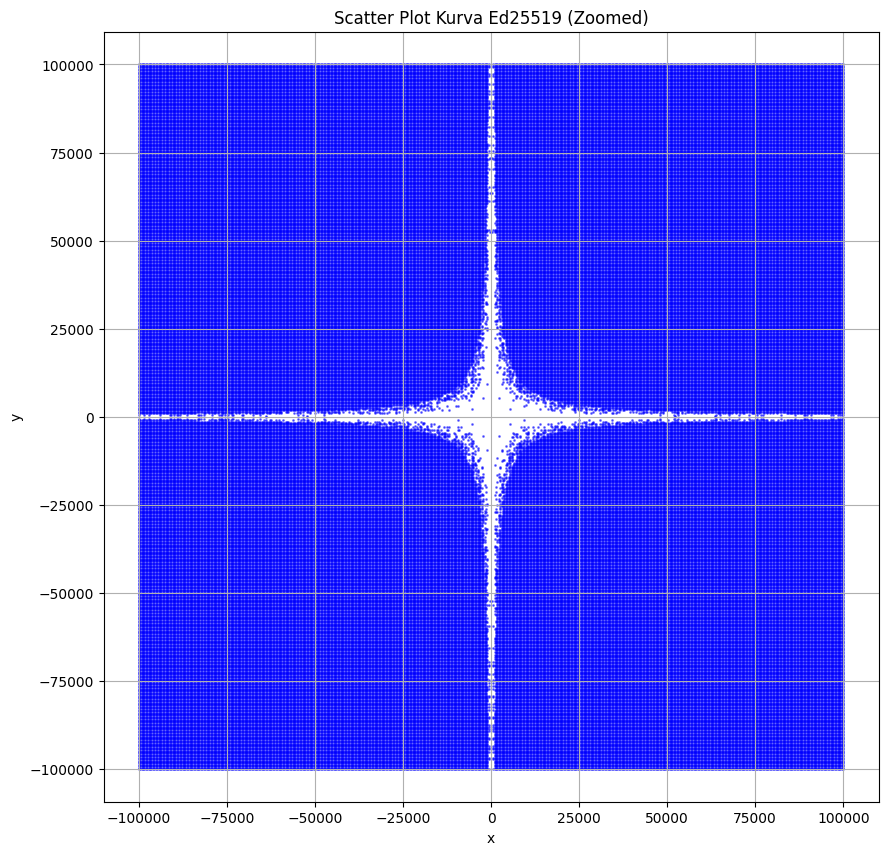

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter kurva Ed25519
p = 2**255 - 19
d = -121665 * pow(121666, p-2, p) % p

# Fungsi untuk mengecek apakah titik memenuhi persamaan kurva
def is_on_curve(x, y):
    return (-x**2 + y**2 - (1 + d * x**2 * y**2)) % p == 0

# Menentukan titik valid dengan scatter plot
x_vals = np.linspace(-1e5, 1e5, 500)
y_vals = np.linspace(-1e5, 1e5, 500)
X, Y = np.meshgrid(x_vals, y_vals)
X_flat, Y_flat = X.flatten(), Y.flatten()

valid_points = [(x, y) for x, y in zip(X_flat, Y_flat) if is_on_curve(x, y)]

# Ekstraksi koordinat valid
valid_x, valid_y = zip(*valid_points)

# Scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(valid_x, valid_y, s=1, c="blue", alpha=0.5)
plt.title("Scatter Plot Kurva Ed25519 (Zoomed)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid()
plt.show()



